# Sprint11課題 深層学習スクラッチディープニューラルネットワーク

## スクラッチによる実装
NumPyなど最低限のライブラリのみを使いアルゴリズムを実装していきます。

前回作成した3層のニューラルネットワークを、クラスを活用することで、任意の構成に拡張しやすいコードに書き換えていきます。その上で、活性化関数や初期値、最適化手法について発展的なものを扱えるようにしていきます。

このようなスクラッチを行うことで、今後各種フレームワークを利用していくにあたり、内部の動きが想像できることを目指します。

### 新たなニューラルネットワーク分類器のクラスを作成する
Sprint9で作成したものとは別に、ニューラルネットワーク分類器のクラスScratchDeepNeuralNetrowkClassifierを作成してください。

### 層などのクラス化
コーディング

クラスにまとめて行くことで、構成を変更しやすい実装にしていきます。

手を加える箇所

層の数
層の種類（今後は畳み込み層など他のタイプの層が登場する）
活性化関数の種類
重みやバイアスの初期化方法
最適化手法
そのために、全結合層、各種活性化関数、重みやバイアスの初期化、最適化手法それぞれのクラスを作成します。

実装方法は自由ですが、簡単な例を紹介します。サンプルコード1のように全結合層と活性化関数のインスタンスを作成し、サンプルコード2,3のようにして使用する。それぞれのクラスについてはこのあと解説します。

サンプルコード1

（ScratchDeepNeuralNetrowkClassifierのfitメソッド内）

```
# self.sigma : ガウス分布の標準偏差
# self.lr : 学習率
# self.n_nodes1 : 1層目のノード数
# self.n_nodes2 : 2層目のノード数
# self.n_output : 出力層のノード数

optimizer = SGD(self.lr)
self.FC1 = FC(self.n_features, self.n_nodes1, SimpleInitializer(self.sigma), optimizer)
self.activation1 = Tanh()
self.FC2 = FC(self.n_nodes1, self.n_nodes2, SimpleInitializer(self.sigma), optimizer)
self.activation2 = Tanh()
self.FC3 = FC(self.n_nodes2, self.n_output, SimpleInitializer(self.sigma), optimizer)
self.activation3 = Softmax()
```

サンプルコード2

（イテレーションごとのフォワード）

```
A1 = self.FC1.forward(X)
Z1 = self.activation1.forward(A1)
A2 = self.FC2.forward(Z1)
Z2 = self.activation2.forward(A2)
A3 = self.FC3.forward(Z2)
Z3 = self.activation3.forward(A3)
```

サンプルコード3

（イテレーションごとのバックワード）

```
A3 = self.activation3.backward(Z3, Y) # 交差エントロピー誤差とソフトマックスを合わせている
dZ2 = self.FC3.backward(dA3)
dA2 = self.activation2.backward(dZ2)
dZ1 = self.FC2.backward(dA2)
dA1 = self.activation1.backward(dZ1)
dZ0 = self.FC1.backward(dA1) # dZ0は使用しない
```


In [1]:
#ライブラリのインポート
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

In [2]:
from keras.datasets import mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()

Using TensorFlow backend.


In [3]:
X_train = X_train.reshape(-1, 784)
X_test = X_test.reshape(-1, 784)

In [4]:
#float型へ
X_train = X_train.astype(np.float)
X_test = X_test.astype(np.float)

#正規化
X_train /= 255
X_test /= 255
print(X_train.max()) # 1.0
print(X_train.min()) # 0.0

1.0
0.0


In [5]:
#データ分割
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)
print(X_train.shape) # (48000, 784)
print(X_val.shape) # (12000, 784)

(48000, 784)
(12000, 784)


## 【問題1】全結合層のクラス化
コーディング

全結合層のクラスの雛形を載せました。コンストラクタで重みやバイアスの初期化をして、あとはフォワードとバックワードのメソッドを用意します。

重みW、バイアスB、およびフォワード時の入力Xをインスタンス変数として保持しておくことで、煩雑な入出力は不要になります。

なお、インスタンスも引数として渡すことができます。そのため、初期化方法のインスタンスinitializerをコンストラクタで受け取れば、それにより初期化が行われます。渡すインスタンスを変えれば、初期化方法が変えられます。

また、引数として自身のインスタンスselfを渡すこともできます。これを利用してself = self.optimizer.update(self)という風に層の重みの更新が可能です。更新に必要な値は複数ありますが、全て全結合層が持つインスタンス変数にすることができます。

初期化方法と最適化手法のクラスについては後述します。

雛形

In [6]:
class FC:
    """
    ノード数n_nodes1からn_nodes2への全結合層
    Parameters
    ----------
    n_nodes1 : int
      前の層のノード数
    n_nodes2 : int
      後の層のノード数
    initializer : 初期化方法のインスタンス
    optimizer : 最適化手法のインスタンス
    
    Attribute
    ------------
    self.W : 重み
    self.B : バイアス
    self.H_w : 前のイテレーションまでの勾配の(重み)二乗和(初期値0)
    self.H_b : 前のイテレーションまでの勾配の(バイアス)二乗和(初期値0)
    self.forward_Z : forward時の入力値(backward用に利用)
    self.dW : 重みの勾配
    self.dB : バイアスの勾配
    """
    def __init__(self, n_nodes1, n_nodes2, initializer, optimizer):
        self.optimizer = optimizer
        
        # 初期化
        # initializerのメソッドを使い、self.Wとself.Bを初期化する
        self.W = initializer.W(n_nodes1, n_nodes2)
        self.B = initializer.B(n_nodes2)
        
        #AdaGard用
        self.H_w = 0
        self.H_b = 0
        
        self.forward_Z=None

    def forward(self, Z):
        """
        フォワード
        Parameters
        ----------
        Z : 次の形のndarray, shape (batch_size, n_nodes1)
            入力
        Returns
        ----------
        A : 次の形のndarray, shape (batch_size, n_nodes2)
            出力
        """
        #backfoward用に保存
        self.forward_Z = Z.copy()
        
        A = (Z @ self.W) + self.B
        
        return A
    
    
    def backward(self, dA):
        """
        バックワード
        Parameters
        ----------
        dA : 次の形のndarray, shape (batch_size, n_nodes2)
            後ろから流れてきた勾配
        Returns
        ----------
        dZ : 次の形のndarray, shape (batch_size, n_nodes1)
            前に流す勾配
        """
        self.dB = dA.copy()
        self.dW = self.forward_Z.T @ dA
        
        #[batch_size, n_nodes2] dot [n_nodes2, n_nodes1]
        #→ [batch_size, n_nodes1]
        dZ = dA @ self.W.T 
        
        # 更新
        self = self.optimizer.update(self)
              
        return dZ


## 【問題2】初期化方法のクラス化
前述のように、全結合層のコンストラクタに初期化方法のインスタンスを渡せるようにします。雛形に必要なコードを書き加えていってください。標準偏差の値（sigma）はコンストラクタで受け取るようにすることで、全結合層のクラス内にこの値（sigma）を渡さなくてすむようになります。

これまで扱ってきた初期化方法はSimpleInitializerクラスと名付けることにします。

雛形

In [7]:
class SimpleInitializer:
    """
    ガウス分布によるシンプルな初期化
    Parameters
    ----------
    sigma : float
      ガウス分布の標準偏差
    """
    
    def __init__(self, sigma):
        self.sigma = sigma
        
    def W(self, n_nodes1, n_nodes2):
        """
        重みの初期化
        Parameters
        ----------
        n_nodes1 : int
          前の層のノード数
        n_nodes2 : int
          後の層のノード数

        Returns
        ----------
        W :
        """
        W = self.sigma * np.random.randn(n_nodes1, n_nodes2)

        return W
    
    def B(self, n_nodes2):
        """
        バイアスの初期化
        Parameters
        ----------
        n_nodes2 : int
          後の層のノード数

        Returns
        ----------
        B :
        """
        B = np.zeros(n_nodes2)

        return B

## 【問題3】最適化手法のクラス化
最適化手法に関しても初期化方法同様に全結合層にインスタンスとして渡します。バックワードのときにself = self.optimizer.update(self)のように更新できるようにします。こちらも雛形を用意しましたので、必要なコードを書き加えていってください。

これまで扱ってきた最適化手法はSGDクラス（Stochastic Gradient Descent、確率的勾配降下法）として作成します。

雛形

In [8]:
class SGD:
    """
    確率的勾配降下法
    Parameters
    ----------
    lr : 学習率
    """
    
    def __init__(self, lr):
        self.lr = lr
        
    def update(self, layer):
        """
        ある層の重みやバイアスの更新
        Parameters
        ----------
        layer : 更新前の層のインスタンス

        Returns
        ----------
        layer : 更新後の層のインスタンス
        """
        layer.W -= self.lr * layer.dW / layer.dB.shape[0]
        layer.B -= np.mean(self.lr * layer.dB, axis=0)
        
        return layer

## 【問題4】活性化関数のクラス化
活性化関数もクラス化を行なってください。

上記サンプルコード3ではソフトマックス関数のバックプロパゲーションに交差エントロピー誤差の計算も含む実装を想定しています。

In [9]:
class Sigmoid():
    """
    sigmoidの計算
    
    Parameters
    -----------
    
    Attribute
    -----------
    self.forward_A : forward時の入力値(backward用に利用)
    """
    
    def __init__(self):
        self.forward_A = None
        
    def forward(self, A):
        """
        フォワードプロパゲーションにおける活性化関数の計算
        
        Parameters
        -----------
        A : 活性化関数計算前
        
        Return
        -----------
        Z : 出力

        """
        #backfoward用に保存
        self.forward_A = A.copy()
        
        Z = 1 / (1 + np.exp(-A))
        
        return Z
    
    def backward(self, dZ):
        """
        バックプロパゲーションにおける活性化関数の計算
        
        Parameters
        -----------
        dZ : 活性化関数計算前
        
        Return
        -----------
        dA : 出力

        """
        sigmoid_A = 1 / (1 + np.exp(-self.forward_A))
        
        dA = dZ * ((1 - sigmoid_A)  * sigmoid_A)
        
        return dA

In [10]:
class Tanh():
    """
    ハイパボリックタンジェントの計算
    
    Parameters
    -----------
    
    Attribute
    -----------
    self.forward_A : forward時の入力値(backward用に利用)
    """
    
    def __init__(self):
        self.forward_A = None
        
    def forward(self, A):
        """
        フォワードプロパゲーションにおける活性化関数の計算
        
        Parameters
        -----------
        A : 活性化関数計算前
        
        Return
        -----------
        Z : 出力

        """
        #backfoward用に保存
        self.forward_A = A.copy()
        
        Z = np.tanh(A)
        
        return Z
    
    def backward(self, dZ):
        """
        バックプロパゲーションにおける活性化関数の計算
        
        Parameters
        -----------
        dZ : 活性化関数計算前
        
        Return
        -----------
        dA : 出力

        """
        dA = dZ * (1 - (np.tanh(self.forward_A) ** 2))
        
        return dA

In [11]:
class Softmax():
    """
    softmaxの計算
    
    Parameters
    -----------
    
    Attribute
    -----------
    self.cost : 交差エントロピー誤差を格納
    """
    
    def __init__(self):
        self.cost = None
        
    def forward(self, A):
        """
        フォワードにおけるソフトマックスの計算
        
        Parameters
        -----------
        A : 活性化関数計算前
        
        Return
        -----------
        Z : 出力
        """
        #オーバーフロー対策
        max_A = np.max(A)

        #最大要素を引いてからexpをかけることでオーバーフローを回避
        exp_A = np.exp(A - max_A)

         #分母を計算
        sum_exp_A = np.sum(exp_A, axis=1).reshape(-1, 1)
        
        Z = exp_A / sum_exp_A

        return Z
        
    
    def backward(self, Z, Y):
        """
        バックワードにおけるソフトマックスと交差エントロピー誤差
        
        Parameters
        -----------
        Z : 出力層で計算された出力
        Y : 正解値
        
        Return
        -----------
        dA : 出力

        """
        #交差エントロピー誤差
        self.cost = - np.sum(Y * np.log(Z), axis=1)

        #バックワード(出力層)
        dA = Z - Y
        
        return dA
    


## 【問題5】ReLUクラスの作成
現在一般的に使われている活性化関数であるReLU（Rectified Linear Unit）をReLUクラスとして実装します。

ReLUは以下の数式です。
$$
% <![CDATA[
f(x) = ReLU(x) = \begin{cases}
x  & \text{if $x>0$,}\\
0 & \text{if $x\leqq0$.}
\end{cases} %]]>
$$

$x$ : ある特徴量。スカラー

実装上はnp.maximumを使い配列に対してまとめて計算が可能です。

[numpy.maximum — NumPy v1.15 Manual](https://docs.scipy.org/doc/numpy-1.15.0/reference/generated/numpy.maximum.html)

一方、バックプロパゲーションのための $x$ に関する $f(x)$ の微分は以下のようになります。

$$
% <![CDATA[
\frac{\partial f(x)}{\partial x} = \begin{cases}
1  & \text{if $x>0$,}\\
0 & \text{if $x\leqq0$.}
\end{cases} %]]>
$$

数学的には微分可能ではないですが、 $x=0$のとき $0$ とすることで対応しています。

フォワード時の $x$ の正負により、勾配を逆伝播するかどうかが決まるということになります。

In [12]:
class Relu():
    """
    ReLUの計算
    
    Parameters
    -----------
    
    Attribute
    -----------
    self.mask : 入力値の0以下を判定するboolリスト
    
    """
    
    def __init__(self):
        self.mask = None     
        
    def forward(self, A):
        """
        フォワードにおける活性化関数の計算
        
        Parameters
        -----------
        A : 活性化関数計算前
        
        Return
        -----------
        Z : 出力

        """
        self.mask = (A <= 0)
        
        Z = A.copy()
        
        Z[self.mask] = 0
        
        return Z
    
    def backward(self, dZ):
        """
        バックワードにおける活性化関数の計算
        
        Parameters
        -----------
        dZ : 活性化関数計算前
        
        Return
        -----------
        dA : 出力

        """        
        dA = dZ.copy()
        
        dA[self.mask] = 0
        
            
        return dA

## 【問題6】重みの初期値
ここまでは重みやバイアスの初期値は単純にガウス分布で、標準偏差をハイパーパラメータとして扱ってきました。しかし、一般的に良い初期値の取り方が知られています。

シグモイド関数やハイパボリックタンジェント関数のときはXavierの初期値（またはGlorotの初期値）、ReLUのときはHeの初期値が使われます。

XavierInitializerクラスと、HeInitializerクラスを作成します。

それぞれの初期化方法における $σ$ は次の式で求められます。

「Xavierの初期値」

$$
\sigma = \frac{1}{\sqrt{n}}
$$

$n$ : 前の層のノード数

（論文）

[Glorot, X., & Bengio, Y. (n.d.). Understanding the difficulty of training deep feedforward neural networks.](http://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf)

「Heの初期値」

$$
\sigma = \sqrt{\frac{2}{n}}
$$

$n$  : 前の層のノード数

（論文）

[He, K., Zhang, X., Ren, S., & Sun, J. (2015). Delving Deep into Rectifiers: Surpassing Human-Level Performance on ImageNet Classification.](https://arxiv.org/pdf/1502.01852.pdf)

In [13]:
class XavierInitializer:
    """
    Xavierによる初期化
    
    Parameters
    ----------
    
    """
    
    def __init__(self):
        pass
        
    def W(self, n_nodes1, n_nodes2):
        """
        重みの初期化
        Parameters
        ----------
        n_nodes1 : int
          前の層のノード数
        n_nodes2 : int
          後の層のノード数

        Returns
        ----------
        W :
        """
        W = np.random.randn(n_nodes1, n_nodes2) / np.sqrt(n_nodes1)

        return W
    
    def B(self, n_nodes2):
        """
        バイアスの初期化
        Parameters
        ----------
        n_nodes2 : int
          後の層のノード数

        Returns
        ----------
        B :
        """
        B = np.zeros(n_nodes2)

        return B

In [14]:
class HeInitializer:
    """
    Heによる初期化
    
    Parameters
    ----------
    
    """
    
    def __init__(self):
        pass
        
    def W(self, n_nodes1, n_nodes2):
        """
        重みの初期化
        Parameters
        ----------
        n_nodes1 : int
          前の層のノード数
        n_nodes2 : int
          後の層のノード数

        Returns
        ----------
        W :
        """
        W = np.random.randn(n_nodes1, n_nodes2) / np.sqrt(n_nodes1) * np.sqrt(2)

        return W
    
    def B(self, n_nodes2):
        """
        バイアスの初期化
        Parameters
        ----------
        n_nodes2 : int
          後の層のノード数

        Returns
        ----------
        B :
        """
        B = np.zeros(n_nodes2)

        return B

## 【問題7】最適化手法
コーディング

学習率は学習の良し悪しにとって重要なハイパーパラメータであり、これを学習過程で変化させていく方法が現在では一般的です。様々な手法が提案されていますが、今回はその中でも基本的な、AdaGradを実装します。

まず、これまで使ってきたSGDを確認します。

$$
W_i^{\prime} = W_i - \alpha E(\frac{\partial L}{\partial W_i}) \\
B_i^{\prime} = B_i - \alpha E(\frac{\partial L}{\partial B_i})
$$

$\alpha$ : 学習率（層ごとに変えることも可能だが、基本的には全て同じとする）

$\frac{\partial L}{\partial W_i}$ : $W_i$に関する損失 $L$ の勾配

$\frac{\partial L}{\partial B_i}$ :$B_i$に関する損失$L$の勾配

$E()$ : ミニバッチ方向にベクトルの平均を計算


続いて、AdaGradです。バイアスの数式は省略しますが、重みと同様のことをします。

更新された分だけその重みに対する学習率を徐々に下げていきます。イテレーションごとの勾配の二乗和$H$を保存しておき、その分だけ学習率を小さくします。

学習率は重み一つひとつに対して異なることになります。

$$
H_i^{\prime}  = H_i+E(\frac{\partial L}{\partial W_i})×E(\frac{\partial L}{\partial W_i})\\
W_i^{\prime} = W_i - \alpha \frac{1}{\sqrt{H_i^{\prime} }} E(\frac{\partial L}{\partial W_i}) \\
$$

$H_i$ : i層目に関して、前のイテレーションまでの勾配の二乗和（初期値は0）

$H_i^{\prime}$ : 更新した$H_i$

AdaGradクラスを作成し、上記の数式にもとづいて実装してください。

（論文）

[Duchi JDUCHI, J., & Singer, Y. (2011). Adaptive Subgradient Methods for Online Learning and Stochastic Optimization * Elad Hazan. Journal of Machine Learning Research (Vol. 12).](http://www.jmlr.org/papers/volume12/duchi11a/duchi11a.pdf)


In [15]:
class AdaGrad:
    """
    AdaGradによる最適化手法
    Parameters
    ----------
    lr : 学習率
    """    
    def __init__(self, lr):
        self.lr = lr
        
    def update(self, layer):
        """
        ある層の重みやバイアスの更新
        Parameters
        ----------
        layer : 更新前の層のインスタンス

        Returns
        ----------
        layer : 更新後の層のインスタンス
        """
        #重みの更新
        layer.H_w += (layer.dW / layer.dB.shape[0]) ** 2
        layer.W -= self.lr * (1 / np.sqrt(layer.H_w + 1e-7)) * (layer.dW / layer.dB.shape[0])

        #バイアスの更新
        layer.H_b += (layer.dB) ** 2        
        layer.B -= np.mean(self.lr * (1 / np.sqrt(layer.H_b + 1e-7)) * layer.dB)

        
        return layer

### クラスにまとめる

In [16]:
#ライブラリインポート
import numpy as np
from sklearn.preprocessing import OneHotEncoder

class ScratchDeepNeuralNetrowkClassifier():
    """
    Deepニューラルネットワーク分類器

    Parameters
    ----------
    verbose : bool
        学習過程を出力する場合はTrue
    n_nodes1 : int(default:100)
        1層目のノード数
    n_nodes2 : int(default:30)
        2層目のノード数
    n_epochs : int(default:30)
        イテレーション数
    lr : flaot (default:1e-3)
        学習率
    batch : int(default :10)
        ミニバッチの単位数
    sigma : float(default:0.01)
        ガウス分布の標準偏差
    opt : str (default: 'sgd')
        最適化手法。'sgd'、'adagrad'より選択。
    act : str (default : 'relu')
        活性化関数。'relu', 'sigmoid', 'tanh'より選択。

    Attributes
    ----------
    self.loss : ndarray,shape(n_epochs, )
        エポックごとの誤差を格納
    self.val_loss : ndarray,shape(n_epochs, )
        エポックごとの誤差(検証用データ)を格納
    self.n_output : int
        出力層のノード数（クラス数）
    self.n_features : int
        入力層のノード数（特徴量の数）
        
        
    """

    def __init__(self, verbose = True, n_nodes1=100, n_nodes2=30, 
                 n_epochs=30, lr=1e-3, batch=10, sigma=0.01, opt='sgd', act='relu'):

        self.verbose = verbose             #True(default):学習過程を表示、False:非表示
        self.n_nodes1 = n_nodes1        #1層目のノード数(default:100)
        self.n_nodes2 = n_nodes2        #2層目のノード数(default:30)
        self.n_epochs = n_epochs        #エポック数(default:30)
        self.lr = lr                                #学習率(default:1e-3)
        self.batch = batch                   #ミニバッチを行うサイズ(default:10)
        self.sigma = sigma                  #ガウス分布の標準偏差
        self.opt = opt                          #最適化手法('sgd' or 'adagrad')
        self.act = act                          #活性化関数('relu' or 'sigmoid' or 'tanh')
        self.loss = np.zeros(n_epochs)
        self.val_loss = np.zeros(n_epochs)
    
    
    def fit(self, X, y, X_val=None, y_val=None):
        """
        ニューラルネットワーク分類器を学習する。

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            学習用データの特徴量
        y : 次の形のndarray, shape (n_samples, )
            学習用データの正解値
        X_val : 次の形のndarray, shape (n_samples, n_features)
            検証用データの特徴量
        y_val : 次の形のndarray, shape (n_samples, )
            検証用データの正解値
        """
        #出力層のノード数
        self.n_output = np.unique(y).shape[0]
        
        #正解データをワンホットエンコーディング
        y = self._onehot(y)
        #検証用データもあればワンホット
        if X_val is not None:
            y_val = self._onehot(y_val)


        #入力層のノード数
        self.n_features = X.shape[1]

        #minibatchデータを生成
        train_minibatch = GetMiniBatch(X, y, batch_size=self.batch)
        

        #最適化手法のインスタンスを選択、生成。
        if self.opt == 'sgd':
            optimizer = SGD(self.lr)
        elif self.opt == 'adagrad':
            optimizer = AdaGrad(self.lr)
        
        #活性化関数の選択
        #'relu'の場合、Heにて初期化
        if self.act == 'relu':
        
            #1層目
            #インスタンス生成、重みの初期化
            self.FC1 = FC(self.n_features, self.n_nodes1, HeInitializer(), optimizer)
            self.activation1 = Relu()        

            #２層目
            #インスタンス生成、重みの初期化
            self.FC2 = FC(self.n_nodes1, self.n_nodes2, HeInitializer(), optimizer)
            self.activation2 = Relu()        

            #3層目(出力層)
            #インスタンス生成、重みの初期化
            self.FC3 = FC(self.n_nodes2, self.n_output, HeInitializer(), optimizer)
            self.activation3 = Softmax()

        #'sigmoid'の場合、Xavierにて初期化
        elif self.act == 'sigmoid':
        
            #1層目
            #インスタンス生成、重みの初期化
            self.FC1 = FC(self.n_features, self.n_nodes1, XavierInitializer(), optimizer)
            self.activation1 = Sigmoid()        

            #２層目
            #インスタンス生成、重みの初期化
            self.FC2 = FC(self.n_nodes1, self.n_nodes2, XavierInitializer(), optimizer)
            self.activation2 = Sigmoid()        

            #3層目(出力層)
            #インスタンス生成、重みの初期化
            self.FC3 = FC(self.n_nodes2, self.n_output, XavierInitializer(), optimizer)
            self.activation3 = Softmax()

        #'tanh'の場合、Xavierにて初期化
        elif self.act == 'tanh':
        
            #1層目
            #インスタンス生成、重みの初期化
            self.FC1 = FC(self.n_features, self.n_nodes1, XavierInitializer(), optimizer)
            self.activation1 = Tanh()        

            #２層目
            #インスタンス生成、重みの初期化
            self.FC2 = FC(self.n_nodes1, self.n_nodes2, XavierInitializer(), optimizer)
            self.activation2 = Tanh()        

            #3層目(出力層)
            #インスタンス生成、重みの初期化
            self.FC3 = FC(self.n_nodes2, self.n_output, XavierInitializer(), optimizer)
            self.activation3 = Softmax()


        #エポック数だけトレーニングを繰り返す
        for epoch in range(self.n_epochs):
                            
            #引数で設定したminibatch数の単位で学習を行う
            for mini_X, mini_y in train_minibatch:
                X = mini_X.copy()
                Y = mini_y.copy()
                                            
                #フォワードプロパゲーション
                A1 = self.FC1.forward(X)
                Z1 = self.activation1.forward(A1)
                A2 = self.FC2.forward(Z1)
                Z2 = self.activation2.forward(A2)
                A3 = self.FC3.forward(Z2)
                Z3 = self.activation3.forward(A3)
                                
                #バックプロパゲーション
                dA3 = self.activation3.backward(Z3, Y) # 交差エントロピー誤差とソフトマックスを合わせている
                dZ2 = self.FC3.backward(dA3)
                dA2 = self.activation2.backward(dZ2)
                dZ1 = self.FC2.backward(dA2)
                dA1 = self.activation1.backward(dZ1)
                dZ0 = self.FC1.backward(dA1) # dZ0は使用しない
                    

            ############
            # 評価
            ############
            #誤差を格納
            self.loss[epoch] = np.mean(self.activation3.cost)
                        
            #検証用データが引数にある場合、処理を行う
            if X_val is not None:
                                
                #フォワードプロパゲーション
                A1_val = self.FC1.forward(X_val)
                Z1_val = self.activation1.forward(A1_val)
                A2_val = self.FC2.forward(Z1_val)
                Z2_val = self.activation2.forward(A2_val)
                A3_val = self.FC3.forward(Z2_val)
                Z3_val = self.activation3.forward(A3_val)
                
                #検証用データの交差エントロピー誤差を計算
                cost_val = self._compute_cost(y_val, Z3_val)

                #誤差を格納
                self.val_loss[epoch] = np.mean(cost_val)
                            

            #verboseをTrueにした際は学習過程などを出力する
            if self.verbose:
                #一度だけ、'Cross Entropy Error'を出力
                if epoch == 0:
                    print('Cross Entropy Error')
                    
                #エポックごとのコスト関数を出力
                print('epoch{} : {}'.format(epoch+1, np.mean(self.activation3.cost)))
                
                #検証用データがある場合、そのコスト関数も出力
                if X_val is not None:
                    print('epoch_val{} : {}'.format(epoch+1, np.mean(cost_val)))

        return self


    def predict(self, X):
        """
        ニューラルネットワーク分類器を使い推定する。

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            サンプル

        Returns
        -------
        y_pred :  次の形のndarray, shape (n_samples, 1)
            推定結果
        """
        #フォワードプロパゲーション
        A1 = self.FC1.forward(X)
        Z1 = self.activation1.forward(A1)
        A2 = self.FC2.forward(Z1)
        Z2 = self.activation2.forward(A2)
        A3 = self.FC3.forward(Z2)
        Z3 = self.activation3.forward(A3)
        
        #出力層の確率から、最大値をそのクラスとする
        y_pred = np.argmax(Z3, axis=1)
        
        return y_pred
    
    def _onehot(self, y):
        """
        多クラス分類を行う際のone-hot表現に変換

        Parameters
        ----------
        y : 次の形のndarray, shape (n_samples, )
            サンプル

        Returns
        -------
        y_one_hot : 次の形のndarray, shape (n_samples, n_classes)
            推定結果
        """
        enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
        y_one_hot = enc.fit_transform(y[:, np.newaxis])
        
        return y_one_hot
    
    
    #交差エントロピー誤差
    def _compute_cost(self, y, y_pred):

        return - np.sum(y * np.log(y_pred), axis=1)
    
    
    
class GetMiniBatch:
    """
    ミニバッチを取得するイテレータ

    Parameters
    ----------
    X : 次の形のndarray, shape (n_samples, n_features)
      学習データ
    y : 次の形のndarray, shape (n_samples, 1)
      正解値
    batch_size : int
      バッチサイズ
    seed : int
      NumPyの乱数のシード
    """
    def __init__(self, X, y, batch_size = 10, seed=0):
        self.batch_size = batch_size
        np.random.seed(seed)
        shuffle_index = np.random.permutation(np.arange(X.shape[0]))
        self.X = X[shuffle_index]
        self.y = y[shuffle_index]
        self._stop = np.ceil(X.shape[0]/self.batch_size).astype(np.int)

    def __len__(self):
        return self._stop

    def __getitem__(self,item):
        p0 = item*self.batch_size
        p1 = item*self.batch_size + self.batch_size
        return self.X[p0:p1], self.y[p0:p1]        

    def __iter__(self):
        self._counter = 0
        return self

    def __next__(self):
        if self._counter >= self._stop:
            raise StopIteration()
        p0 = self._counter*self.batch_size
        p1 = self._counter*self.batch_size + self.batch_size
        self._counter += 1
        return self.X[p0:p1], self.y[p0:p1]

### 最適化・活性化関数の組み合わせにてfittng
※変化を確認するためパラメータはは同一とする

### 最適化：SGD × 活性化 : Sigmoid

In [17]:
sdnnc_sgd_sigmoid = ScratchDeepNeuralNetrowkClassifier(
    verbose = True, 
    n_nodes1=100, 
    n_nodes2=30, 
    n_epochs=30, 
    lr=1e-2, 
    batch=10, 
    sigma=0.01, 
    opt='sgd', 
    act='sigmoid')

sdnnc_sgd_sigmoid.fit(X_train, y_train, X_val, y_val)

Cross Entropy Error
epoch1 : 1.525575630241547
epoch_val1 : 1.5481785769236
epoch2 : 0.7121410032921558
epoch_val2 : 0.7616094417957269
epoch3 : 0.41989552482372555
epoch_val3 : 0.5280512873833041
epoch4 : 0.2849074191391331
epoch_val4 : 0.4328018508142819
epoch5 : 0.2135177827736669
epoch_val5 : 0.38098641953147033
epoch6 : 0.1706112706775232
epoch_val6 : 0.3478876196262426
epoch7 : 0.1413541144121897
epoch_val7 : 0.3241691901249741
epoch8 : 0.11940147079033081
epoch_val8 : 0.3056674671284073
epoch9 : 0.10180363204776781
epoch_val9 : 0.2903488908773179
epoch10 : 0.08708491655154586
epoch_val10 : 0.2771481327850896
epoch11 : 0.07454606642444102
epoch_val11 : 0.2654732596963266
epoch12 : 0.06392646345496608
epoch_val12 : 0.25497758396212594
epoch13 : 0.05513476144965981
epoch_val13 : 0.24544532361683677
epoch14 : 0.04805235064059596
epoch_val14 : 0.23673016304802338
epoch15 : 0.04247342537004113
epoch_val15 : 0.2287224609476427
epoch16 : 0.03814327329504128
epoch_val16 : 0.2213332020950

<function matplotlib.pyplot.show(*args, **kw)>

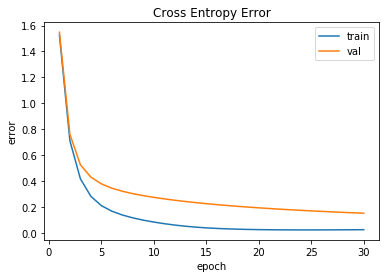

In [18]:
plt.plot(np.arange(1, len(sdnnc_sgd_sigmoid.loss) + 1, 1), sdnnc_sgd_sigmoid.loss, label='train')
plt.plot(np.arange(1, len(sdnnc_sgd_sigmoid.val_loss) + 1, 1), sdnnc_sgd_sigmoid.val_loss, label='val')


plt.title('Cross Entropy Error')
plt.xlabel('epoch')
plt.ylabel('error')

plt.legend()
plt.show

In [19]:
print(classification_report(y_val, sdnnc_sgd_sigmoid.predict(X_val)))

              precision    recall  f1-score   support

           0       0.96      0.98      0.97      1224
           1       0.97      0.98      0.98      1317
           2       0.96      0.96      0.96      1178
           3       0.96      0.94      0.95      1252
           4       0.94      0.96      0.95      1223
           5       0.96      0.93      0.94      1053
           6       0.96      0.98      0.97      1172
           7       0.97      0.97      0.97      1236
           8       0.94      0.95      0.94      1155
           9       0.95      0.93      0.94      1190

   micro avg       0.96      0.96      0.96     12000
   macro avg       0.96      0.96      0.96     12000
weighted avg       0.96      0.96      0.96     12000



### 最適化：SGD × 活性化 : Tanh

In [20]:
sdnnc_sgd_tanh = ScratchDeepNeuralNetrowkClassifier(
    verbose = True, 
    n_nodes1=100, 
    n_nodes2=30, 
    n_epochs=30, 
    lr=1e-2, 
    batch=10, 
    sigma=0.01, 
    opt='sgd', 
    act='tanh')

sdnnc_sgd_tanh.fit(X_train, y_train, X_val, y_val)

Cross Entropy Error
epoch1 : 0.11144815609970835
epoch_val1 : 0.3043110379659466
epoch2 : 0.04699065178484688
epoch_val2 : 0.24146653982791363
epoch3 : 0.030228997637657306
epoch_val3 : 0.2037927579072803
epoch4 : 0.024586886476379934
epoch_val4 : 0.17811603829083258
epoch5 : 0.02296980805732831
epoch_val5 : 0.15990035044723036
epoch6 : 0.022533829577044525
epoch_val6 : 0.14642930511711963
epoch7 : 0.02153207491220597
epoch_val7 : 0.13609111015321576
epoch8 : 0.019533777046067048
epoch_val8 : 0.12790075456167047
epoch9 : 0.016894212757550493
epoch_val9 : 0.12131906074059316
epoch10 : 0.01403828432715907
epoch_val10 : 0.11600257158920313
epoch11 : 0.011305095207415987
epoch_val11 : 0.11165622205558366
epoch12 : 0.008944786957653602
epoch_val12 : 0.10805773194640092
epoch13 : 0.0070743618787242266
epoch_val13 : 0.10506359765569345
epoch14 : 0.005668995151743931
epoch_val14 : 0.10257611246337672
epoch15 : 0.0046321034739272805
epoch_val15 : 0.10050941235486079
epoch16 : 0.0038637356590414

<function matplotlib.pyplot.show(*args, **kw)>

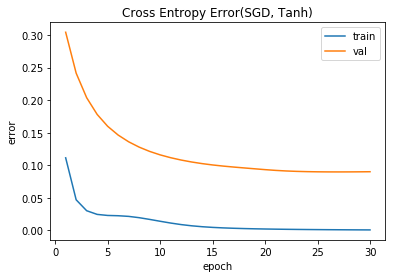

In [21]:
plt.plot(np.arange(1, len(sdnnc_sgd_tanh.loss) + 1, 1), sdnnc_sgd_tanh.loss, label='train')
plt.plot(np.arange(1, len(sdnnc_sgd_tanh.val_loss) + 1, 1), sdnnc_sgd_tanh.val_loss, label='val')


plt.title('Cross Entropy Error(SGD, Tanh)')
plt.xlabel('epoch')
plt.ylabel('error')

plt.legend()
plt.show

In [22]:
print(classification_report(y_val, sdnnc_sgd_tanh.predict(X_val)))

              precision    recall  f1-score   support

           0       0.98      0.99      0.98      1224
           1       0.99      0.99      0.99      1317
           2       0.96      0.98      0.97      1178
           3       0.98      0.97      0.97      1252
           4       0.98      0.97      0.98      1223
           5       0.97      0.95      0.96      1053
           6       0.98      0.98      0.98      1172
           7       0.98      0.96      0.97      1236
           8       0.97      0.97      0.97      1155
           9       0.95      0.97      0.96      1190

   micro avg       0.97      0.97      0.97     12000
   macro avg       0.97      0.97      0.97     12000
weighted avg       0.97      0.97      0.97     12000



### 最適化：SGD × 活性化 : ReLU

In [23]:
sdnnc_sgd_relu = ScratchDeepNeuralNetrowkClassifier(
    verbose = True, 
    n_nodes1=100, 
    n_nodes2=30, 
    n_epochs=30, 
    lr=1e-2, 
    batch=10, 
    sigma=0.01, 
    opt='sgd', 
    act='relu')

sdnnc_sgd_relu.fit(X_train, y_train, X_val, y_val)

Cross Entropy Error
epoch1 : 0.07124001344115895
epoch_val1 : 0.24887944274803317
epoch2 : 0.04297980846868035
epoch_val2 : 0.19057378965158076
epoch3 : 0.04094927552179982
epoch_val3 : 0.15911314752122926
epoch4 : 0.03270653351295107
epoch_val4 : 0.1388509378655024
epoch5 : 0.025636263249634555
epoch_val5 : 0.12569137712206505
epoch6 : 0.019598766001079036
epoch_val6 : 0.11702278585832646
epoch7 : 0.015003387282526006
epoch_val7 : 0.1111159815789309
epoch8 : 0.008871781178571252
epoch_val8 : 0.10694957618254063
epoch9 : 0.005909747350020854
epoch_val9 : 0.10393166389348626
epoch10 : 0.0036562577862792956
epoch_val10 : 0.10172203171509117
epoch11 : 0.00266475275424473
epoch_val11 : 0.10039815460442503
epoch12 : 0.0016822368544000869
epoch_val12 : 0.09919344258604124
epoch13 : 0.0010464413882178016
epoch_val13 : 0.09884860419251681
epoch14 : 0.0008177495348274169
epoch_val14 : 0.09798148432611917
epoch15 : 0.0007218298919922316
epoch_val15 : 0.09749365179884925
epoch16 : 0.0006009980737

<function matplotlib.pyplot.show(*args, **kw)>

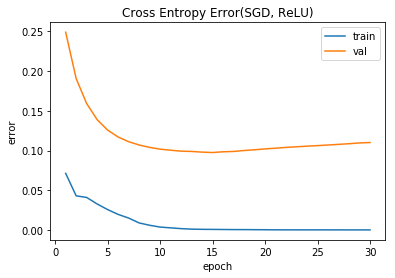

In [24]:
plt.plot(np.arange(1, len(sdnnc_sgd_relu.loss) + 1, 1), sdnnc_sgd_relu.loss, label='train')
plt.plot(np.arange(1, len(sdnnc_sgd_relu.val_loss) + 1, 1), sdnnc_sgd_relu.val_loss, label='val')


plt.title('Cross Entropy Error(SGD, ReLU)')
plt.xlabel('epoch')
plt.ylabel('error')

plt.legend()
plt.show

In [25]:
print(classification_report(y_val, sdnnc_sgd_relu.predict(X_val)))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98      1224
           1       0.99      0.99      0.99      1317
           2       0.95      0.98      0.97      1178
           3       0.97      0.96      0.97      1252
           4       0.98      0.97      0.98      1223
           5       0.98      0.95      0.97      1053
           6       0.98      0.98      0.98      1172
           7       0.98      0.97      0.98      1236
           8       0.97      0.96      0.96      1155
           9       0.95      0.97      0.96      1190

   micro avg       0.97      0.97      0.97     12000
   macro avg       0.97      0.97      0.97     12000
weighted avg       0.97      0.97      0.97     12000



### 最適化：AdaGrad × 活性化 : Sigmoid

In [26]:
sdnnc_adagrad_sigmoid = ScratchDeepNeuralNetrowkClassifier(
    verbose = True, 
    n_nodes1=100, 
    n_nodes2=30, 
    n_epochs=30, 
    lr=1e-2, 
    batch=10, 
    sigma=0.01, 
    opt='adagrad', 
    act='sigmoid')

sdnnc_adagrad_sigmoid.fit(X_train, y_train, X_val, y_val)

Cross Entropy Error
epoch1 : 0.26001834604462093
epoch_val1 : 0.4003696462503526
epoch2 : 0.14819799898698555
epoch_val2 : 0.3120266690931076
epoch3 : 0.1051134256284179
epoch_val3 : 0.2742058824111747
epoch4 : 0.08325387173284203
epoch_val4 : 0.25153714920302733
epoch5 : 0.07020588259251981
epoch_val5 : 0.23575920823281407
epoch6 : 0.061548724047433154
epoch_val6 : 0.22381020261731147
epoch7 : 0.05538218429803708
epoch_val7 : 0.21426669488764674
epoch8 : 0.05076994650266059
epoch_val8 : 0.20636847922743748
epoch9 : 0.04719725584357788
epoch_val9 : 0.19966534444821926
epoch10 : 0.04435545221270078
epoch_val10 : 0.1938674460159813
epoch11 : 0.04204663835889484
epoch_val11 : 0.1887761886971278
epoch12 : 0.04013724962954633
epoch_val12 : 0.18424948970105598
epoch13 : 0.038533509660516205
epoch_val13 : 0.18018249451707755
epoch14 : 0.037167535729216314
epoch_val14 : 0.17649592522680904
epoch15 : 0.03598898637826115
epoch_val15 : 0.17312861842990404
epoch16 : 0.03495976825774969
epoch_val16

<function matplotlib.pyplot.show(*args, **kw)>

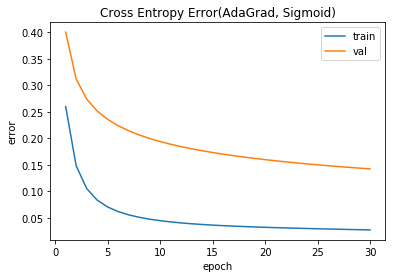

In [27]:
plt.plot(np.arange(1, len(sdnnc_adagrad_sigmoid.loss) + 1, 1), sdnnc_adagrad_sigmoid.loss, label='train')
plt.plot(np.arange(1, len(sdnnc_adagrad_sigmoid.val_loss) + 1, 1), sdnnc_adagrad_sigmoid.val_loss, label='val')


plt.title('Cross Entropy Error(AdaGrad, Sigmoid)')
plt.xlabel('epoch')
plt.ylabel('error')

plt.legend()
plt.show

In [28]:
print(classification_report(y_val, sdnnc_adagrad_sigmoid.predict(X_val)))

              precision    recall  f1-score   support

           0       0.97      0.98      0.97      1224
           1       0.97      0.98      0.98      1317
           2       0.96      0.96      0.96      1178
           3       0.96      0.94      0.95      1252
           4       0.95      0.96      0.96      1223
           5       0.96      0.93      0.95      1053
           6       0.97      0.98      0.97      1172
           7       0.97      0.97      0.97      1236
           8       0.94      0.94      0.94      1155
           9       0.95      0.94      0.95      1190

   micro avg       0.96      0.96      0.96     12000
   macro avg       0.96      0.96      0.96     12000
weighted avg       0.96      0.96      0.96     12000



### 最適化：AdaGrad × 活性化 : Tanh

In [29]:
sdnnc_adagrad_tanh = ScratchDeepNeuralNetrowkClassifier(
    verbose = True, 
    n_nodes1=100, 
    n_nodes2=30, 
    n_epochs=30, 
    lr=1e-2, 
    batch=10, 
    sigma=0.01, 
    opt='adagrad', 
    act='tanh')

sdnnc_adagrad_tanh.fit(X_train, y_train, X_val, y_val)

Cross Entropy Error
epoch1 : 0.056908013342791997
epoch_val1 : 0.2217762292116976
epoch2 : 0.03581823786263283
epoch_val2 : 0.18533085551372544
epoch3 : 0.028246793512321493
epoch_val3 : 0.1657662899948883
epoch4 : 0.023903584638262892
epoch_val4 : 0.15273354804610575
epoch5 : 0.020535239760483805
epoch_val5 : 0.1431799937873038
epoch6 : 0.017737362609343832
epoch_val6 : 0.1358110950119264
epoch7 : 0.01542837224523711
epoch_val7 : 0.12992076306582995
epoch8 : 0.01353801029789116
epoch_val8 : 0.1250790996518081
epoch9 : 0.01199217205245973
epoch_val9 : 0.12101114633493304
epoch10 : 0.010722155817003507
epoch_val10 : 0.1175338162908063
epoch11 : 0.009670677430171963
epoch_val11 : 0.11452073851325205
epoch12 : 0.008792481799745322
epoch_val12 : 0.11188171199675147
epoch13 : 0.008052161175663711
epoch_val13 : 0.10955018230240643
epoch14 : 0.007421804201621822
epoch_val14 : 0.10747548215864064
epoch15 : 0.006879234250913762
epoch_val15 : 0.10561807452652336
epoch16 : 0.006406804110110767
ep

<function matplotlib.pyplot.show(*args, **kw)>

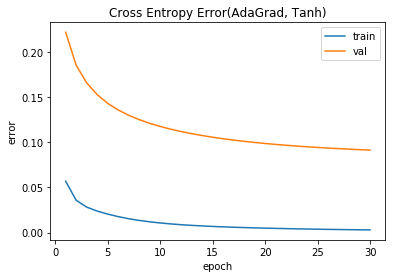

In [30]:
plt.plot(np.arange(1, len(sdnnc_adagrad_tanh.loss) + 1, 1), sdnnc_adagrad_tanh.loss, label='train')
plt.plot(np.arange(1, len(sdnnc_adagrad_tanh.val_loss) + 1, 1), sdnnc_adagrad_tanh.val_loss, label='val')


plt.title('Cross Entropy Error(AdaGrad, Tanh)')
plt.xlabel('epoch')
plt.ylabel('error')

plt.legend()
plt.show

In [31]:
print(classification_report(y_val, sdnnc_adagrad_tanh.predict(X_val)))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98      1224
           1       0.97      0.98      0.98      1317
           2       0.96      0.98      0.97      1178
           3       0.97      0.96      0.97      1252
           4       0.97      0.98      0.97      1223
           5       0.98      0.95      0.97      1053
           6       0.98      0.98      0.98      1172
           7       0.98      0.97      0.97      1236
           8       0.97      0.96      0.96      1155
           9       0.97      0.96      0.96      1190

   micro avg       0.97      0.97      0.97     12000
   macro avg       0.97      0.97      0.97     12000
weighted avg       0.97      0.97      0.97     12000



### 最適化：AdaGrad × 活性化 : ReLU

In [32]:
sdnnc_adagrad_relu = ScratchDeepNeuralNetrowkClassifier(
    verbose = True, 
    n_nodes1=100, 
    n_nodes2=30, 
    n_epochs=30, 
    lr=1e-2, 
    batch=10, 
    sigma=0.01, 
    opt='adagrad', 
    act='relu')

sdnnc_adagrad_relu.fit(X_train, y_train, X_val, y_val)

Cross Entropy Error
epoch1 : 0.02740767736764162
epoch_val1 : 0.1854186714210288
epoch2 : 0.01893693547687662
epoch_val2 : 0.15425942391330022
epoch3 : 0.017471867678406302
epoch_val3 : 0.13891169417020377
epoch4 : 0.016779332402433268
epoch_val4 : 0.1294067775545815
epoch5 : 0.01619103290528308
epoch_val5 : 0.12258603483215445
epoch6 : 0.01470276948504121
epoch_val6 : 0.11737734009514073
epoch7 : 0.013186496194646315
epoch_val7 : 0.11335849019984115
epoch8 : 0.011689444343652326
epoch_val8 : 0.1100731202335215
epoch9 : 0.010253616874069286
epoch_val9 : 0.10746856563470425
epoch10 : 0.009166281218712196
epoch_val10 : 0.10526398810981179
epoch11 : 0.00812839092189164
epoch_val11 : 0.10339012133026704
epoch12 : 0.007209287852485069
epoch_val12 : 0.10163509326367752
epoch13 : 0.006184581864073396
epoch_val13 : 0.10020097320555338
epoch14 : 0.0054912741911025175
epoch_val14 : 0.09898470199412969
epoch15 : 0.0049008939971948995
epoch_val15 : 0.09783221137626608
epoch16 : 0.00423942207068741

<function matplotlib.pyplot.show(*args, **kw)>

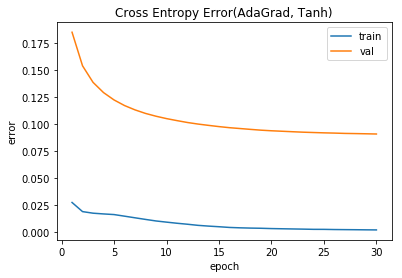

In [33]:
plt.plot(np.arange(1, len(sdnnc_adagrad_relu.loss) + 1, 1), sdnnc_adagrad_relu.loss, label='train')
plt.plot(np.arange(1, len(sdnnc_adagrad_relu.val_loss) + 1, 1), sdnnc_adagrad_relu.val_loss, label='val')


plt.title('Cross Entropy Error(AdaGrad, Tanh)')
plt.xlabel('epoch')
plt.ylabel('error')

plt.legend()
plt.show

In [34]:
print(classification_report(y_val, sdnnc_adagrad_relu.predict(X_val)))

              precision    recall  f1-score   support

           0       0.98      0.99      0.98      1224
           1       0.98      0.99      0.99      1317
           2       0.96      0.98      0.97      1178
           3       0.97      0.96      0.97      1252
           4       0.98      0.98      0.98      1223
           5       0.98      0.95      0.96      1053
           6       0.97      0.98      0.98      1172
           7       0.98      0.97      0.97      1236
           8       0.96      0.96      0.96      1155
           9       0.95      0.96      0.96      1190

   micro avg       0.97      0.97      0.97     12000
   macro avg       0.97      0.97      0.97     12000
weighted avg       0.97      0.97      0.97     12000



### pyファイルで確認

In [35]:
#pyファイル格納ディレクトリのパス設定
import sys
sys.path.append("/Users/yusuke-saruya/diveintocode-ml/full-time/diveintocode-term2/ml-scratch/utils/")
import deepneuralnetrowk


In [36]:
sdnnc_py = deepneuralnetrowk.ScratchDeepNeuralNetrowkClassifier(
    verbose = True, 
    n_nodes1=100, 
    n_nodes2=30, 
    n_epochs=5, 
    lr=1e-2, 
    batch=10, 
    sigma=0.01, 
    opt='sgd', 
    act='relu')

sdnnc_py.fit(X_train, y_train, X_val, y_val)

Cross Entropy Error
epoch1 : 0.07124001344115895
epoch_val1 : 0.24887944274803317
epoch2 : 0.04297980846868035
epoch_val2 : 0.19057378965158076
epoch3 : 0.04094927552179982
epoch_val3 : 0.15911314752122926
epoch4 : 0.03270653351295107
epoch_val4 : 0.1388509378655024
epoch5 : 0.025636263249634555
epoch_val5 : 0.12569137712206505
